# Group 4 Assignment 2 

### Authors: 
-  Chin Yee Wan 
-  Darrel Koh
-  Nguyen Gia Khanh 
-  Ngo Vu Anh	

### Main Steps
1.  Data Preprocessing 
-   Read in as SPARK dataframe for data preprocessing
-   Convert to Pandas dataframe for data exploration
2.  Data Exploration
3.  Data Modelling
4.  Data Evaluation

# Discover and Visualise the Data

## Import Libraries

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler, VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.mllib.evaluation import BinaryClassificationMetrics

from sklearn.metrics import confusion_matrix, classification_report

## Functions definition 

### Read in file

In [2]:
train_df = pd.read_csv('GA2Datasets/UNSW_NB15_training-set.csv')
test_df = pd.read_csv('GA2Datasets/UNSW_NB15_testing-set.csv')

In [3]:
spark = SparkSession.builder \
                            .appName("CSCI316GP2")\
                            .config("spark.sql.files.maxPartitionBytes", "1000000")\
                            .getOrCreate()

23/08/14 20:39:29 WARN Utils: Your hostname, Darrels-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.0.192 instead (on interface en0)
23/08/14 20:39:29 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/14 20:39:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
spark_df = spark.createDataFrame(train_df)
spark_df.show()

23/08/14 20:39:42 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
23/08/14 20:39:42 WARN TaskSetManager: Stage 0 contains a task of very large size (1416 KiB). The maximum recommended task size is 1000 KiB.


+---+------+-----+-------+-----+-----+-----+------+------+-----------+----+----+-------------+-----+-----+-----+---------+------+----+----+----+-----+-----+----+------+------+------+-----+-----+-----------+-----------------+----------+------------+----------+----------------+----------------+--------------+------------+----------+----------------+----------+----------+---------------+----------+-----+
| id|   dur|proto|service|state|spkts|dpkts|sbytes|dbytes|       rate|sttl|dttl|        sload|dload|sloss|dloss|   sinpkt|dinpkt|sjit|djit|swin|stcpb|dtcpb|dwin|tcprtt|synack|ackdat|smean|dmean|trans_depth|response_body_len|ct_srv_src|ct_state_ttl|ct_dst_ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|is_ftp_login|ct_ftp_cmd|ct_flw_http_mthd|ct_src_ltm|ct_srv_dst|is_sm_ips_ports|attack_cat|label|
+---+------+-----+-------+-----+-----+-----+------+------+-----------+----+----+-------------+-----+-----+-----+---------+------+----+----+----+-----+-----+----+------+------+------+-----+--

#### Custom pipeline for data pre-processing

In [5]:
class PreProcessPipeline:
    def __init__(self, label_encode = True, process_label = 'Binary'):
        self.label_encode = label_encode
        self.process_label = process_label
    
    def fit(self):
        return self

    def transform(self, df):
        df = df.drop('id', axis=1)
        df = df.copy()
        if self.label_encode:
            columns = ['proto', 'service', 'state', 'attack_cat']
            for column in columns:
                unique_values = df[column].unique()
                mapping = {value: index for index, value in enumerate(unique_values)}
                df[column] = df[column].map(mapping)

        if self.process_label == 'Binary':
            df.drop('attack_cat', axis=1, inplace=True)
        else:             
            df['attack_cat'], df['label'] = df['label'], df['attack_cat']
            print('change name')
            df.drop('attack_cat', axis=1, inplace=True)      

        return df

#### Dataframe Pipeline

In [6]:
'''
Author: Khanh Nguyen
Name: PySpark Dataframe Pipeline
Description:
    This class is used to create a pipeline for PySpark dataframe, accept 2 boolean parameter: smote & standardize.
    Features 
        (Default)
        - Resample: Resample the dataframe
        - Vectorize: Vectorize the dataframe
        (activate by setting the parameter to True):
        - SMOTE: Oversampling the minority class
        - Standardize: Standardize the dataframe using z-score
'''

from pyspark.sql.functions import col
class SparkDFPipeline:
    def __init__(self, smote=False, standardize=False):
        self.smote = smote
        self.standardize = standardize
    
    def fit(self):
        return self
    
    def transform(self, train_df, test_df):
        if self.smote:
            majority = train_df.filter(col('label') == 0)
            minority = train_df.filter(col('label') == 1)

            majority_count = majority.count()
            minority_count = minority.count()

            ratio = int(majority_count / minority_count)
            sample_num = int(ratio * minority_count) - minority_count
            sample = minority.sample(True, sample_num / minority_count, seed=42)
            balanced_sample = minority.union(sample)
            train_df = majority.union(balanced_sample).orderBy('label')
        
        if self.standardize:
            # Standardize the df

            # Resample the df
            num_partitions = 500
            repartitioned_df = train_df.repartition(num_partitions)

            exclude = ['proto', 'service', 'state']
            input_columns = train_df.columns[:-1]
            selected_columns = [col for col in input_columns if col not in exclude]
            # Vectorize the df
            assembler = VectorAssembler(inputCols=selected_columns, outputCol='features')
            train_df = assembler.transform(repartitioned_df)
            test_df = assembler.transform(test_df)

            # Standardize the df
            scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withStd=True, withMean=True)
            scaler_model = scaler.fit(train_df)
            train_df = scaler_model.transform(train_df)

            scaler_model = scaler.fit(test_df)
            test_df = scaler_model.transform(test_df)
            test_df = test_df.drop('features')
            train_df = train_df.drop('features')
            
            # put back the categorical columns
            input_cols = ['scaled_features', 'proto', 'service', 'state']
            output_col = "features"
            assembler1 = VectorAssembler(inputCols=input_cols, outputCol=output_col)
            train_df = assembler1.transform(train_df)
            test_df = assembler1.transform(test_df)

            # return result
            test_df = test_df.select('features', 'label')
            train_df = train_df.select('features', 'label')
        else:
            # Normal vectorize df
            num_partitions = 500
            repartitioned_df = train_df.repartition(num_partitions)
            input_columns = train_df.columns[:-1]
            assembler = VectorAssembler(inputCols=input_columns, outputCol='features')
            train_df = assembler.transform(repartitioned_df)
            train_df = train_df.select('features', 'label')
            test_df = assembler.transform(test_df)
              
        return train_df, test_df

#### For Visualisation

In [7]:
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)

#### For Evaluation

In [49]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Define your class labels
class_labels = ['Normal', 'Generic', 'Exploits', 'Fuzzers', 'DoS', 'Reconnaissance', 'Analysis', 'Backdoor', 'Shellcode', 'Worms']

def evaluate_model(model, val_data, model_name):
    # Make predictions on the validation data
    predictions = model.transform(val_data)

    acc_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    accuracy = acc_evaluator.evaluate(predictions)

    f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
    f1_score = f1_evaluator.evaluate(predictions)

    # AUC_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="areaUnderROC")
    # AUC_score = AUC_evaluator.evaluate(predictions)

    # AUPR_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="areaUnderPR")
    # AUPR_score = AUPR_evaluator.evaluate(predictions)

    precision_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
    precision_score = precision_evaluator.evaluate(predictions)

    recall_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
    recall_score = recall_evaluator.evaluate(predictions)
    
    # Convert Spark DataFrames to Pandas DataFrames for visualization
    y_true_pd = predictions.select('label').toPandas()
    y_pred_pd = predictions.select('prediction').toPandas()

    # Generate the confusion matrix
    cm = confusion_matrix(y_true_pd['label'], y_pred_pd['prediction'])

    # Get the predicted counts for each class label
    predicted_counts = y_pred_pd['prediction'].value_counts()

    # Create a dictionary to store the counts of each class label
    class_counts = {label: 0 for label in class_labels}

    # Fill in the dictionary with actual predicted counts where available
    for key, count in predicted_counts.items():
        class_counts[class_labels[int(key)]] = count

    # Convert the dictionary values to a list
    predicted_counts_list = [class_counts[label] for label in class_labels]

    # Display the confusion matrix as a heatmap with sorted class labels and counts
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels[::-1], yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(model_name)
    plt.show()


    # Create a dictionary of model evaluation metrics
    eval_metrics = {
        'Accuracy': accuracy
        , 'F1 Score': f1_score
        # , 'Area Under ROC': AUC_score
        # , 'Area Under PR': AUPR_score
        , 'Precision': precision_score
        , 'Recall': recall_score
    }

    return eval_metrics


## Data Exploration

### Explore train_df 

In [9]:
train_df.isnull().sum()

id                   0
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat 

In [10]:
pipeline = PreProcessPipeline(label_encode=True, process_label='Multi')
train_df = pipeline.transform(train_df)
test_df = pipeline.transform(test_df)

change name
change name


## Data Visualisation

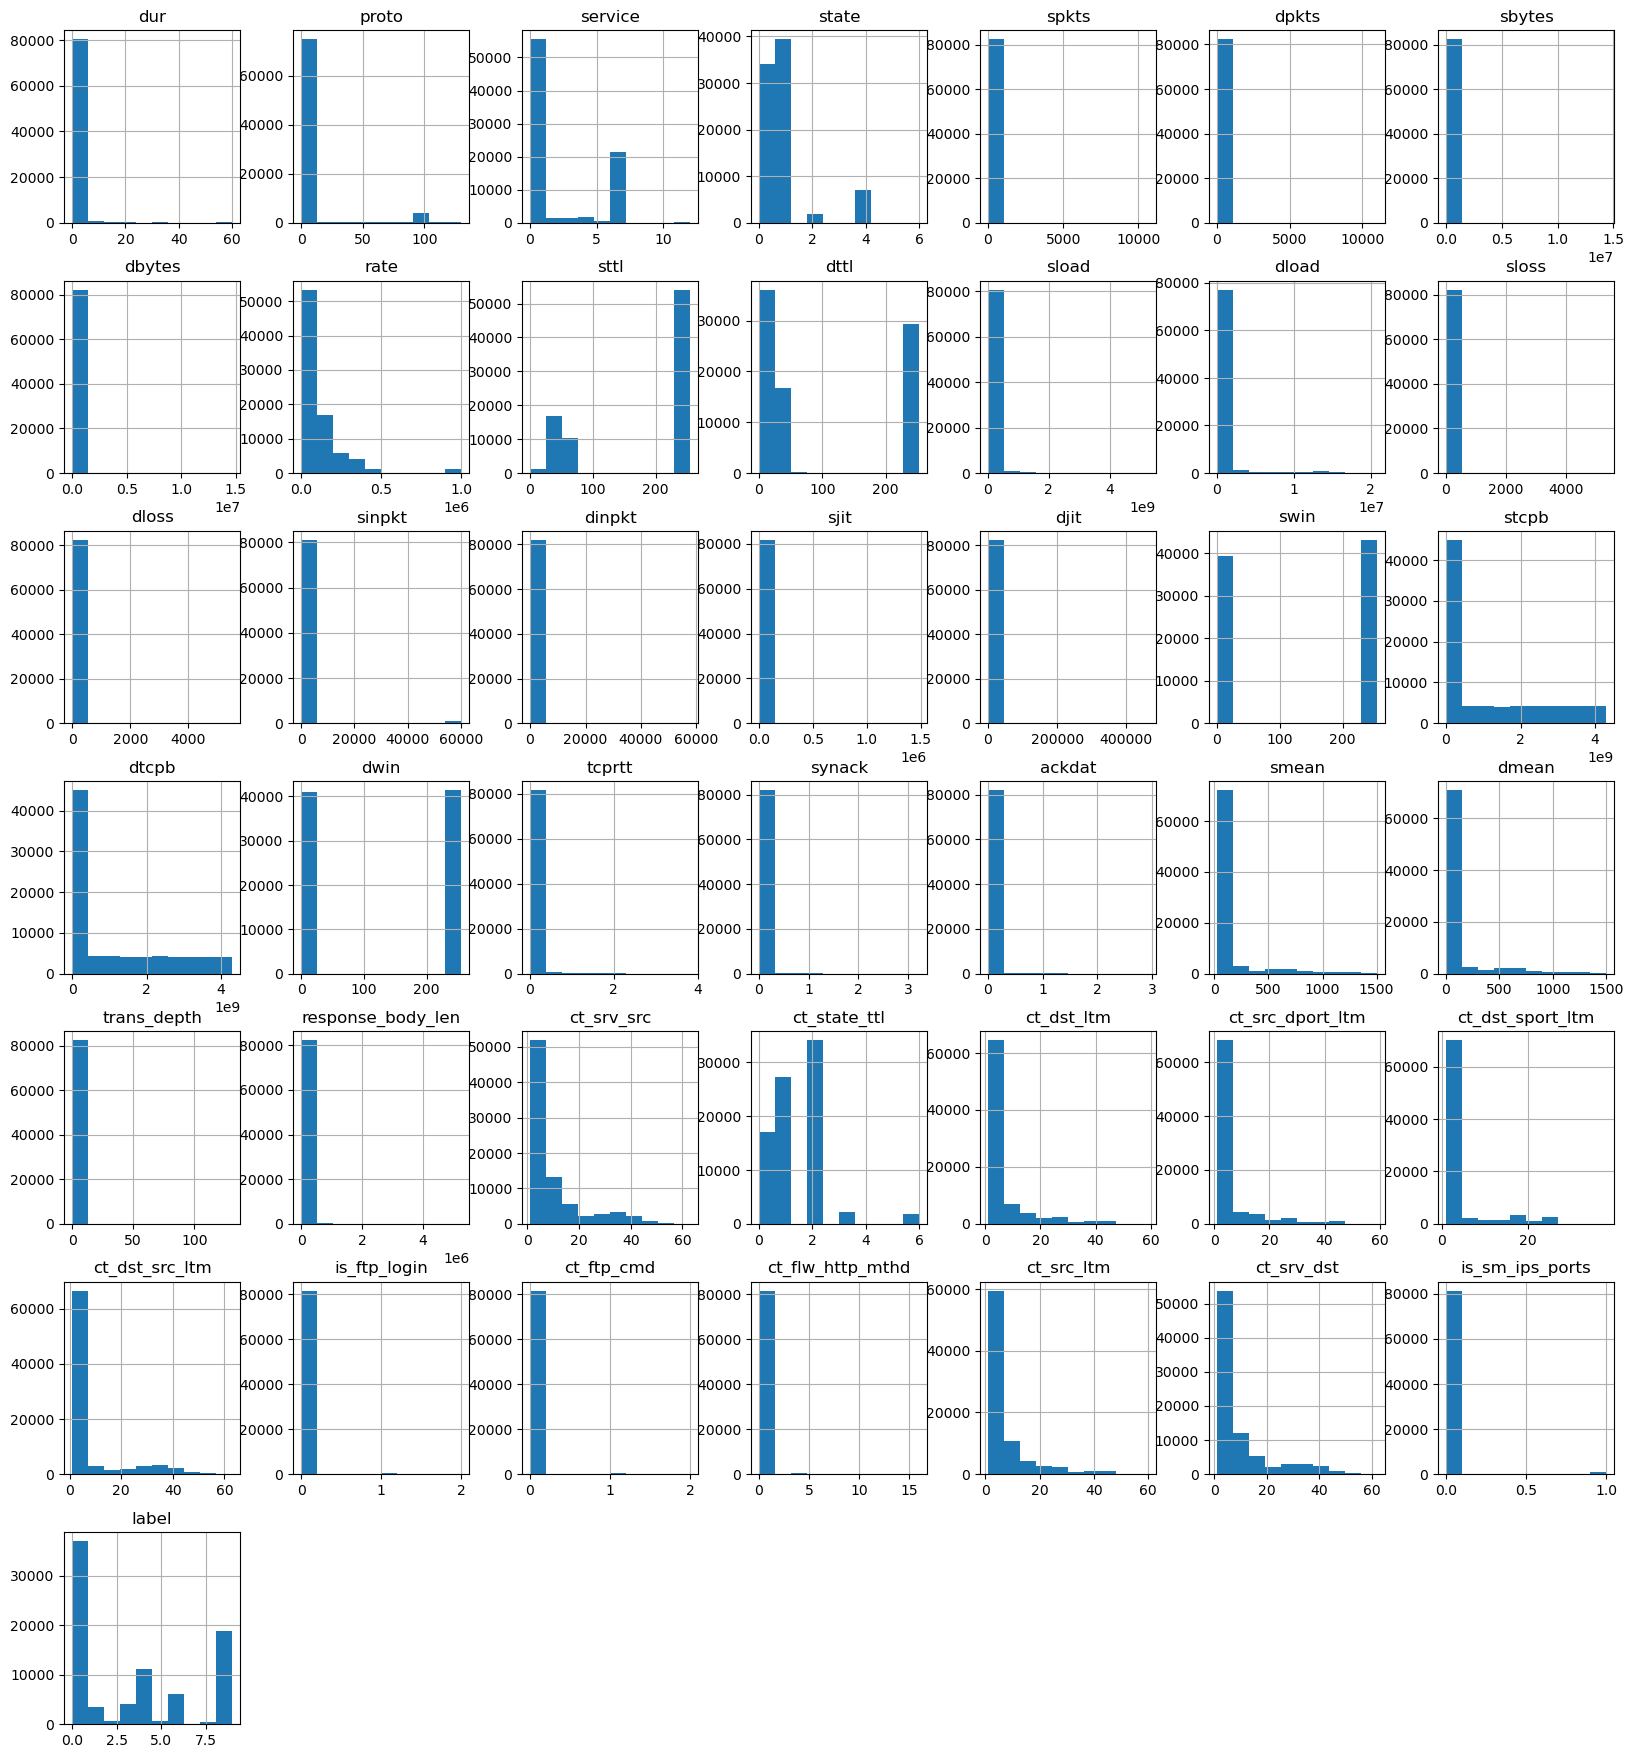

In [11]:
rcParams["figure.figsize"]=(20,22)
train_df.hist()
plt.grid()

# Prepare the data

### Convert Pandas DF to Spark DF

In [12]:
sparktrain_df = spark.createDataFrame(train_df)
sparktest_df = spark.createDataFrame(test_df)

### Feature enabler

##### for Default

In [13]:
pipeline = SparkDFPipeline(smote=False, standardize=False)
train, test = pipeline.transform(sparktrain_df, sparktest_df)

In [14]:
train

23/08/14 20:40:14 WARN TaskSetManager: Stage 1 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 20:40:15 WARN TaskSetManager: Stage 4 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.


features,label
"[0.269164,2.0,1.0...",4
"(42,[0,1,4,6,8,9,...",6
"(42,[0,1,4,6,8,9,...",4
"[0.671838,2.0,0.0...",1
"[0.671307,2.0,0.0...",1
"(42,[0,1,4,6,8,9,...",3
"(42,[0,1,4,6,8,9,...",6
"[0.774819,2.0,4.0...",4
"(42,[0,1,4,6,8,9,...",3
"(42,[0,1,4,6,8,9,...",4


In [15]:
test

23/08/14 20:40:16 WARN TaskSetManager: Stage 7 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 20:40:16 WARN TaskSetManager: Stage 8 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.


dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label,features
0.121478,0,0,0,6,4,258,172,74.08749,252,254,14158.94238,8495.365234,0,0,24.2956,8.375,30.177547,11.830604,255,621772692,2202533631,255,0.0,0.0,0.0,43,43,0,0,1,0,1,1,1,1,0,0,0,1,1,0,0,"[0.121478,0.0,0.0..."
0.649902,0,0,0,14,38,734,42014,78.473372,62,252,8395.112305,503571.3125,2,17,49.915,15.432865,61.426934,1387.77833,255,1417884146,3077387971,255,0.0,0.0,0.0,52,1106,0,0,43,1,1,1,1,2,0,0,0,1,6,0,0,"[0.649902,0.0,0.0..."
1.623129,0,0,0,8,16,364,13186,14.170161,62,252,1572.271851,60929.23047,1,6,231.875571,102.737203,17179.58686,11420.92623,255,2116150707,2963114973,255,0.111897,0.061458,0.050439,46,824,0,0,7,1,2,1,1,3,0,0,0,2,6,0,0,"[1.623129,0.0,0.0..."
1.681642,0,1,0,12,12,628,770,13.677108,62,252,2740.178955,3358.62207,1,3,152.876547,90.235726,259.080172,4991.784669,255,1107119177,1047442890,255,0.0,0.0,0.0,52,64,0,0,1,1,2,1,1,3,1,1,0,2,1,0,0,"[1.681642,0.0,1.0..."
0.449454,0,0,0,10,6,534,268,33.373826,254,252,8561.499023,3987.059814,2,1,47.750333,75.659602,2415.837634,115.807,255,2436137549,1977154190,255,0.128381,0.071147,0.057234,53,45,0,0,43,1,2,2,1,40,0,0,0,2,39,0,0,"[0.449454,0.0,0.0..."
0.380537,0,0,0,10,6,534,268,39.41798,254,252,10112.02539,4709.134766,2,1,39.928778,52.241,2223.730342,82.5505,255,3984155503,1796040391,255,0.172934,0.119331,0.053603,53,45,0,0,43,1,2,2,1,40,0,0,0,2,39,0,0,"[0.380537,0.0,0.0..."
0.637109,0,0,0,10,8,534,354,26.683033,254,252,6039.783203,3892.58374,2,1,68.267778,81.137711,4286.82857,119.422719,255,1787309226,1767180493,255,0.143337,0.069136,0.074201,53,44,0,0,43,1,1,1,1,40,0,0,0,1,39,0,0,"[0.637109,0.0,0.0..."
0.521584,0,0,0,10,8,534,354,32.593026,254,252,7377.527344,4754.74707,2,1,55.794,66.054141,3770.580726,118.962633,255,205985702,316006300,255,0.116615,0.059195,0.05742,53,44,0,0,43,1,3,3,1,40,0,0,0,3,39,0,0,"[0.521584,0.0,0.0..."
0.542905,0,0,0,10,8,534,354,31.313031,254,252,7087.796387,4568.018555,2,1,60.210889,68.109,4060.625597,106.611547,255,884094874,3410317203,255,0.118584,0.066133,0.052451,53,44,0,0,43,1,3,3,1,40,0,0,0,3,39,0,0,"[0.542905,0.0,0.0..."
0.258687,0,0,0,10,6,534,268,57.985135,254,252,14875.12012,6927.291016,2,1,27.505111,39.106801,1413.686415,57.200395,255,3368447996,584859215,255,0.087934,0.063116,0.024818,53,45,0,0,43,1,3,3,1,40,0,0,0,3,39,0,0,"[0.258687,0.0,0.0..."


##### for Fine Tuning

In [16]:
pipeline = SparkDFPipeline(smote=False, standardize=True)
FT_train, FT_test = pipeline.transform(sparktrain_df, sparktest_df)

23/08/14 20:40:16 WARN TaskSetManager: Stage 9 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 20:40:18 WARN TaskSetManager: Stage 15 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.


In [17]:
FT_train

23/08/14 20:40:19 WARN TaskSetManager: Stage 18 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 20:40:19 WARN TaskSetManager: Stage 21 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.


features,label
[-0.1565865302747...,4
[-0.2137265740846...,6
[-0.2137278478498...,4
[-0.0711011779642...,1
[-0.0712139061813...,1
[-0.2137280601440...,3
[-0.2137265740846...,6
[-0.0492389095628...,4
[0.03495866616626...,3
[-0.2137265740846...,4


In [18]:
FT_test

23/08/14 20:40:20 WARN TaskSetManager: Stage 24 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 20:40:20 WARN TaskSetManager: Stage 25 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.


features,label
[-0.1910282644245...,0
[-0.1094844824357...,0
[0.04069910179508...,0
[0.04972853898095...,0
[-0.1404166278570...,0
[-0.1510515589413...,0
[-0.1114586350158...,0
[-0.1292858824805...,0
[-0.1259957310570...,0
[-0.1698548491691...,0


# Model selection and training
- Select machine learning models (Logistic Regression , Decision Tree, Random Forest, Multilayer perceptron).
- Split the data into training and validation sets.
- Train the selected models using the training data.

## Logistic Regression model

### Default Model

In [19]:
lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=10, regParam=0.01, elasticNetParam=0.8)

# Train the model
model = lr.fit(train)

# Make predictions on the test data
predictions = model.transform(test)

# Evaluate the model's performance
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

23/08/14 20:40:20 WARN TaskSetManager: Stage 26 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 20:40:20 WARN TaskSetManager: Stage 27 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 20:40:23 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/08/14 20:40:31 WARN TaskSetManager: Stage 70 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 20:40:32 WARN TaskSetManager: Stage 71 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.


Accuracy: 0.529339971826327


In [20]:
# usage for default model
lr_default = LogisticRegression(featuresCol='features', labelCol='label', maxIter=10)
pipeline_default = Pipeline(stages=[lr_default])
model_default = pipeline_default.fit(train)  # Use the 'train' dataset

23/08/14 20:40:32 WARN TaskSetManager: Stage 73 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 20:40:33 WARN TaskSetManager: Stage 74 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 20:40:39 WARN TaskSetManager: Stage 111 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.


###  Fine-Tuning 

In [21]:
# usage for fine-tuned models
lr_tuned = LogisticRegression(featuresCol='features', labelCol='label', maxIter=10)
pipeline_tuned = Pipeline(stages=[lr_tuned])
model_tuned = pipeline_tuned.fit(FT_train)  # Use the 'FT_train' dataset

23/08/14 20:40:39 WARN TaskSetManager: Stage 112 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 20:40:39 WARN TaskSetManager: Stage 113 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 20:40:46 WARN TaskSetManager: Stage 150 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.


In [46]:
# Define the stages for your pipeline
assembler = VectorAssembler(inputCols=['features'], outputCol='assembled_features')
lr = LogisticRegression(featuresCol='assembled_features', labelCol='label', maxIter=10)

# Create a pipeline with the defined stages
pipeline = Pipeline(stages=[assembler, lr])

# Define the ParamGrid
paramGrid = ParamGridBuilder() \
    .addGrid(lr.maxIter, [10, 20, 30]) \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .build()

# Instantiate CrossValidator with the pipeline and paramGrid
cv = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)

# Fit the CrossValidator on your training data
best_tuned_model = cv.fit(FT_train).bestModel



23/08/14 21:10:09 WARN TaskSetManager: Stage 1727 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 21:10:16 WARN TaskSetManager: Stage 1763 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 21:11:20 WARN TaskSetManager: Stage 2159 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 21:11:25 WARN TaskSetManager: Stage 2195 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 21:12:19 WARN TaskSetManager: Stage 2582 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 21:12:25 WARN TaskSetManager: Stage 2618 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 21:13:17 WARN TaskSetManager: Stage 3005 contains a task of very large size (1366 KiB). The maximum recommended task size is 10

### Evaluation

23/08/14 21:17:05 WARN TaskSetManager: Stage 3164 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 21:17:06 WARN TaskSetManager: Stage 3166 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 21:17:06 WARN TaskSetManager: Stage 3168 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 21:17:07 WARN TaskSetManager: Stage 3170 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 21:17:07 WARN TaskSetManager: Stage 3172 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 21:17:07 WARN TaskSetManager: Stage 3173 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.


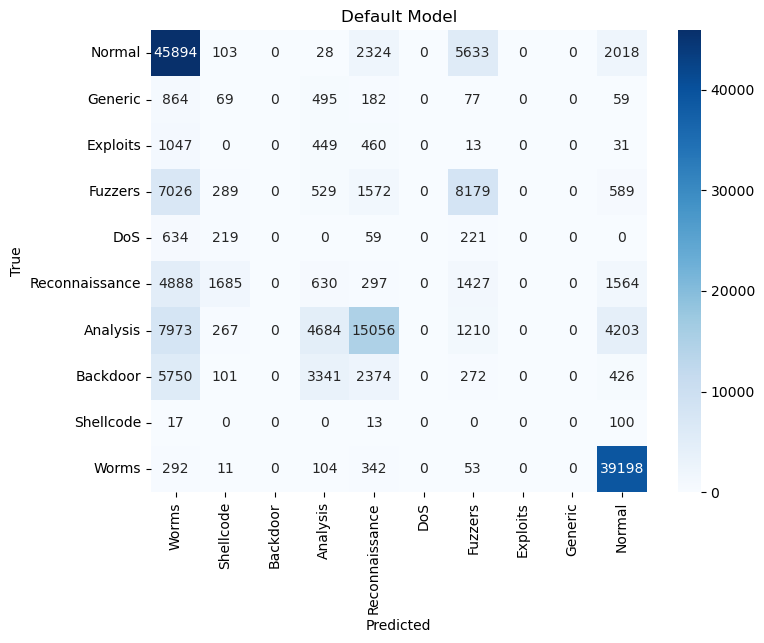

23/08/14 21:17:08 WARN TaskSetManager: Stage 3174 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 21:17:09 WARN TaskSetManager: Stage 3176 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 21:17:09 WARN TaskSetManager: Stage 3178 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 21:17:10 WARN TaskSetManager: Stage 3180 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 21:17:10 WARN TaskSetManager: Stage 3182 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 21:17:11 WARN TaskSetManager: Stage 3183 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.


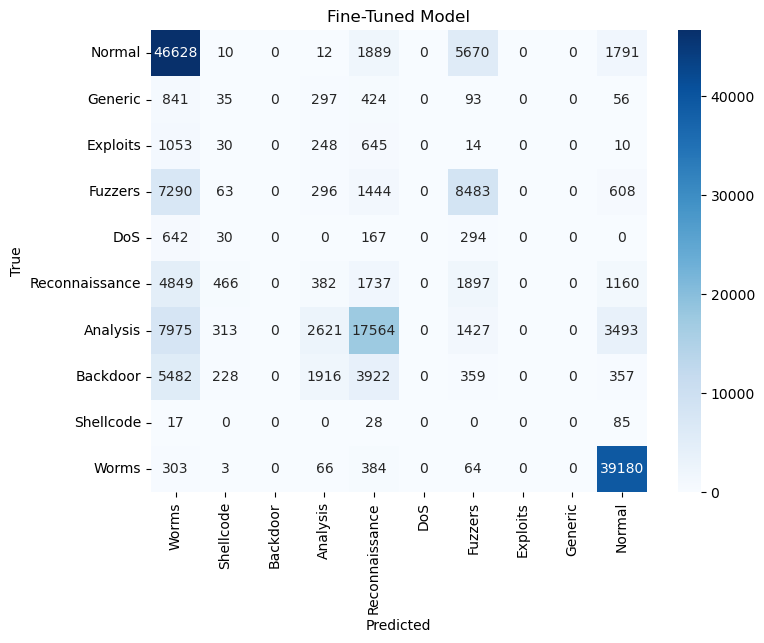

23/08/14 21:17:12 WARN TaskSetManager: Stage 3184 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 21:17:12 WARN TaskSetManager: Stage 3186 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 21:17:12 WARN TaskSetManager: Stage 3188 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 21:17:13 WARN TaskSetManager: Stage 3190 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 21:17:13 WARN TaskSetManager: Stage 3192 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/14 21:17:14 WARN TaskSetManager: Stage 3193 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.


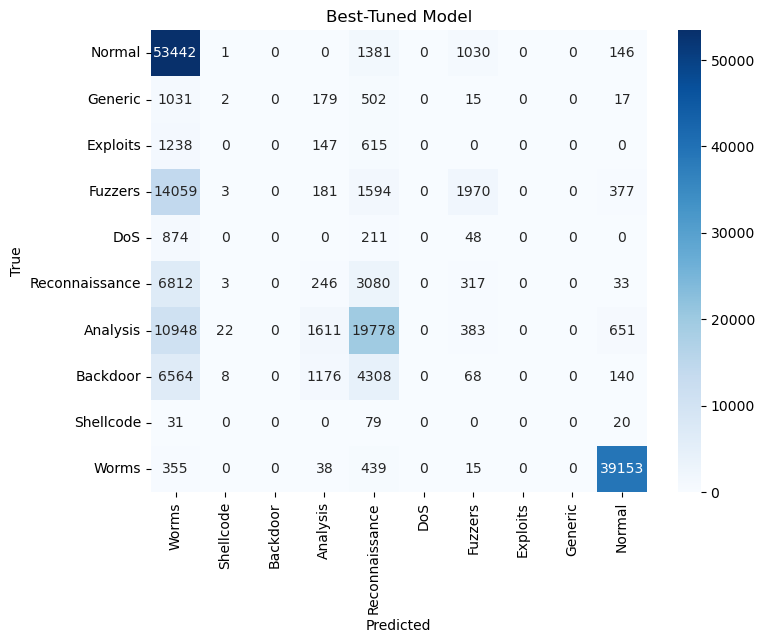

Evaluation Results:
Metric              Default Model       Fine-Tuned Model    Best-Tuned Model    
Accuracy            0.495942            0.500356            0.532517            
F1 Score            0.440957            0.446689            0.453095            
Precision           0.401719            0.410018            0.424101            
Recall              0.495942            0.500356            0.532517            


In [50]:
# Evaluate models using the evaluate_model_multiclass function
evaluation_results_default = evaluate_model(model_default, test, 'Default Model')  # Use the 'test' dataset

# Evaluate models using the evaluate_model_multiclass function
evaluation_results_tuned = evaluate_model(model_tuned, FT_test, 'Fine-Tuned Model')  # Use the 'FT_test' dataset

# Corrected variable name
evaluation_results_best_tuned = evaluate_model(best_tuned_model, FT_test, 'Best-Tuned Model')  # Use the 'FT_test' dataset

# Print evaluation results for all models side by side
print("Evaluation Results:")
print(f"{'Metric':<20}{'Default Model':<20}{'Fine-Tuned Model':<20}{'Best-Tuned Model':<20}")
print("=" * 80)

for metric in evaluation_results_default.keys():
    default_value = evaluation_results_default[metric]
    tuned_value = evaluation_results_tuned[metric]
    best_tuned_value = evaluation_results_best_tuned[metric]
    print(f"{metric:<20}{default_value:<20.6f}{tuned_value:<20.6f}{best_tuned_value:<20.6f}")


##### Sci-kit Learn

In [ ]:
# from sklearn.metrics import confusion_matrix, classification_report

# def evaluate_model_with_visualization(model, val_data, model_name):
#     # Make predictions on the validation data
    # predictions = model.transform(val_data)

#     # Evaluate the model using a BinaryClassificationEvaluator for AUC
#     auc_evaluator = BinaryClassificationEvaluator(labelCol='label')
#     auc = auc_evaluator.evaluate(predictions)

#     # Calculate additional metrics
#     sensitivity = predictions.filter("label = 1 and prediction = 1").count() / predictions.filter("label = 1").count()
#     specificity = predictions.filter("label = 0 and prediction = 0").count() / predictions.filter("label = 0").count()
#     precision = predictions.filter("prediction = 1").count() / predictions.filter("prediction = 1 or prediction = 0").count()
#     recall = sensitivity
#     f1_score = 2 * (precision * recall) / (precision + recall)
#     accuracy = (predictions.filter("label = prediction").count()) / predictions.count()

#     # Convert Spark DataFrames to Pandas DataFrames for visualization
#     y_true_pd = predictions.select('label').toPandas()
#     y_pred_pd = predictions.select('prediction', 'probability').toPandas()
    
#     # Convert prediction probabilities to binary predictions
#     y_pred_binary = [1 if prob[1] >= 0.5 else 0 for prob in y_pred_pd['probability']]

#     # Generate the confusion matrix
#     cm = confusion_matrix(y_true_pd['label'], y_pred_binary)

#     # Display the confusion matrix as a heatmap
#     plt.figure(figsize=(6, 4))
#     sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-default', 'Default'], 
#                 yticklabels=['Non-default', 'Default'])
#     plt.xlabel('Predicted')
#     plt.ylabel('True')
#     plt.title(model_name)
#     plt.show()

#     # Generate the classification report
#     report = classification_report(y_true_pd['label'], y_pred_binary, target_names=['Non-default', 'Default'], output_dict=True)

#     # Create a summary table
#     summary_table = pd.DataFrame({
#         'Model': [model_name],
#         'AUC': [auc],
#         'Sensitivity': [sensitivity],
#         'Specificity': [specificity],
#         'Precision': [precision],
#         'Recall': [recall],
#         'F1-Score': [f1_score],
#         'Accuracy': [accuracy],
#         'Precision (Non-default)': [report['Non-default']['precision']],
#         'Recall (Non-default)': [report['Non-default']['recall']],
#         'F1-score (Non-default)': [report['Non-default']['f1-score']],
#         'Precision (Default)': [report['Default']['precision']],
#         'Recall (Default)': [report['Default']['recall']],
#         'F1-score (Default)': [report['Default']['f1-score']],
#     })

#     return summary_table

# # Assuming you have 'model_default' and 'test' DataFrame from your pipeline
# evaluation_results_default = evaluate_model_with_visualization(model_default, test, 'Default Model')
# print(evaluation_results_default)


In [ ]:
# from sklearn.metrics import confusion_matrix

# # Assuming you have the true labels and predicted labels for your test data
# true_labels = test.select('label').rdd.flatMap(lambda x: x).collect()
# predicted_labels = model_default.transform(test).select('prediction').rdd.flatMap(lambda x: x).collect()

# # Calculate the confusion matrix
# cm = confusion_matrix(true_labels, predicted_labels)

# # Print the confusion matrix
# print("Confusion Matrix:")
# print(cm)

## Decision Tree Model

### Default Model

###  Fine-Tuning 

### Evaluation

## Random Forest Model

### Default Model

###  Fine-Tuning 

### Evaluation

## Multilayer perceptron Model

### Default Model

###  Fine-Tuning 

### Evaluation

# Final comparison between Models